In [161]:
animal = 'AE2'
unit = '001'
trial = '043'

file_path = 'D:\\2P_data\\F\\%s\\u%s_%s\\1\\F_%s_u%s_%s_plane1_proc.mat' % (animal, unit, trial, animal, unit, trial)
analyzer_path = 'H:\\2P_nhp_test\\AnalyzerFiles\\%s\\%s_u%s_%s.analyzer' % (animal, animal, unit, trial)
plot = 'y'
plot_gaussian_fit = 'n'

In [162]:
import scipy.io as sio
import functions

F = sio.loadmat(file_path, squeeze_me=True, struct_as_record=False)['dat']
params = functions.analyzer_params(analyzer_path)
trial_num, stim_time = functions.analyzer_pg_conds(analyzer_path)
trial_num['direction'] = trial_num.ori
trial_num.ori[(trial_num.ori >= 180)] = trial_num.ori[(trial_num.ori >= 180)] - 180

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

mean_image = F.mimg[:, :, 1]
roi_mask = np.zeros(mean_image.shape, dtype=bool)
ori_mask = np.zeros(mean_image.shape)
ori_mask[:, :] = -1

ori_info = pd.DataFrame(columns=['ori_pref', 'osi'])
pref_cells = pd.DataFrame(columns=['expt', 'x', 'y', 'ori_pref'])

for i, cell in enumerate(F.stat):
    if cell.iscell == 1:
        roi_mask[(cell.ypix-1), (cell.xpix-1)] = True
        
        scans = int(F.Fcell.shape[1] / trial_num.shape[0])
        t = np.linspace(stim_time[0] * -1, stim_time.sum() - stim_time[1], scans)
        cell_F = pd.DataFrame(np.reshape(F.Fcell[i, :], (int(F.Fcell.shape[1] / scans), scans)))
        cell_F.insert(0, 'Orientation', trial_num.ori)
        cell_F.insert(1, 'Spatial Frequency', trial_num.s_freq)
        cell_F.insert(2, 'Baseline',
                      np.reshape(F.Fcell[i, :], (int(F.Fcell.shape[1] / scans), scans))[:, 0:int(np.floor(scans * stim_time[0] / stim_time.sum()))].mean(axis=1))
        
        start_sample = int(np.ceil(scans * (stim_time[0] + 0.5) / stim_time.sum()))
        end_sample = int(scans - np.ceil(scans * (stim_time[1]) / stim_time.sum()))
        
        cell_F.iloc[:, -scans:] = cell_F.iloc[:, -scans:].subtract(cell_F['Baseline'], axis=0).divide(cell_F['Baseline'],
                                                                                                      axis=0)
        
        cell_F_stim = pd.DataFrame(cell_F.iloc[:, -(scans-start_sample):-(scans-end_sample)].mean(axis=1), columns=['Mean'])
        cell_F_stim.insert(0, 'Orientation', trial_num.ori)
        cell_F_stim.insert(1, 'Spatial Frequency', trial_num.s_freq)
        counts_ori = cell_F_stim.groupby(['Orientation', 'Spatial Frequency']).mean()
        counts_sf = cell_F_stim.groupby(['Spatial Frequency', 'Orientation']).mean()
        sem_ori = cell_F_stim.groupby(['Orientation', 'Spatial Frequency']).sem()
        sem_sf = cell_F_stim.groupby(['Spatial Frequency', 'Orientation']).sem()
        
        s_freq_max = counts_ori.unstack(level=1).mean(axis=0).idxmax()
        orientation_max = counts_ori.unstack(level=1).mean(axis=1).idxmax()
        
        # Use vector averaging to calculate the preferred orientation (Ohki et al., 2005)
        ori = np.deg2rad(counts_sf.Mean[s_freq_max[1]].index.values)
        responses = counts_sf.Mean[s_freq_max[1]].values
        a = np.sum(responses * np.cos(2 * ori))
        b = np.sum(responses * np.sin(2 * ori))
        ori_pref_vector = np.rad2deg(0.5 * np.arctan(b / a))
        
        # F_stim_sf_max = cell_F_stim[cell_F_stim['Spatial Frequency'] == s_freq_max[1]]
        # list_F_stim = [F_stim_sf_max[F_stim_sf_max['Orientation'] == deg]['Mean'] for deg in np.rad2deg(ori)]
        list_F_stim = [cell_F_stim[cell_F_stim['Orientation'] == deg]['Mean'] for deg in np.rad2deg(ori)]
        F_value, p = sp.stats.f_oneway(*list_F_stim)
        
        if plot_gaussian_fit == 'y':
            # fit gaussian curve to orientation curve, calculate preferred orientation and OSI
            x = counts_sf['Mean'][s_freq_max[1]].index.values
            y = counts_sf['Mean'][s_freq_max[1]].values.T
    
            x_new = np.linspace(x.min(), x.max(), 100)
    
            n = len(x)
            mean = sum(x * y) / n
            sigma = sum(y * (x - mean) ** 2) / n
    
            from scipy.optimize import curve_fit
    
            popt, pcov = curve_fit(functions.gaus, x, y, p0=[1, mean, sigma], maxfev=1000000)
            ori_pref = x_new[np.argmax(functions.gaus(x_new, *popt))]
            r_pref = functions.gaus(ori_pref, *popt)
            r_orth = functions.gaus(ori_pref + 90, *popt)
            osi = (r_pref - r_orth) / r_pref
        
        else:
            ori_pref = counts_sf['Mean'][s_freq_max[1]].idxmax()
            r_pref = counts_sf['Mean'][s_freq_max[1]].loc[ori_pref]
            if ori_pref < 90:
                ori_orth = ori_pref + 90
            else:
                ori_orth = ori_pref - 90
            r_orth = counts_sf['Mean'][s_freq_max[1]].loc[ori_orth]
            osi = (r_pref - r_orth) / r_pref
        
        if p < 0.01:
            if osi > 0.5:
                ori_mask[(cell.ypix - 1), (cell.xpix - 1)] = ori_pref
                
                if plot == 'y':
                    fig, (ax1, ax2) = plt.subplots(2, 1)
                    colors = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
                    
                    counts_ori['Mean'][orientation_max].plot(ax=ax1, linewidth=2, legend=False)
                    ax1.fill_between(sem_ori['Mean'][orientation_max].index.values,
                                     counts_ori['Mean'][orientation_max].values - sem_ori['Mean'][orientation_max].values,
                                     counts_ori['Mean'][orientation_max].values + sem_ori['Mean'][orientation_max].values,
                                     alpha=0.5)
                    ax1.set_title('Spatial Frequency Tuning')
                    ax1.set_ylabel(r'Response ($\Delta F/F$)')
                    ax1.set_xlabel('Spatial Frequency (cycles/degree)')
                    
                    counts_sf['Mean'][s_freq_max[1]].plot(ax=ax2, linewidth=2, legend=False)
                    ax2.fill_between(sem_sf['Mean'][s_freq_max[1]].index.values,
                                     counts_sf['Mean'][s_freq_max[1]].values - sem_sf['Mean'][s_freq_max[1]].values,
                                     counts_sf['Mean'][s_freq_max[1]].values + sem_sf['Mean'][s_freq_max[1]].values,
                                     alpha=0.5)
                    if plot_gaussian_fit == 'y':
                        ax2.plot(x_new, functions.gaus(x_new, *popt), 'r--', label='fit')
                    
                    ax2.set_title('Orientation Tuning')
                    ax2.set_ylabel(r'Response ($\Delta F/F$)')
                    ax2.set_xlabel('Orientation (degrees)')      
                    # plt.suptitle('Pref. Orientation: %.2f, OSI: %.2f' % (ori_pref, osi))
                    plt.tight_layout()
                    
                    plt.savefig('H:/nhp_cells/cell%d.pdf' % i, format='pdf', bbox_inches='tight')
                    plt.close()
                    
                x_med, y_med = cell.med
                pref_cells.loc[i] = [analyzer_path[-17:-9], x_med, y_med, ori_pref]
                pref_cells.to_csv('H:/nhp_cells/%s_ori_pref_df.csv' % analyzer_path[-17:-9])
        ori_info.loc[i] = np.array([ori_pref, osi])

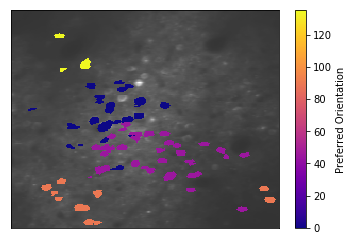

In [205]:
from matplotlib.colors import ColorConverter

cmap = plt.cm.get_cmap('plasma')
cmap.set_under(ColorConverter.to_rgba('white', alpha=0))

fig, ax = plt.subplots()
ax.imshow(mean_image, cmap='gray', alpha=0.8)
im = ax.imshow(ori_mask, cmap=cmap, vmin=0, origin='lower', aspect='auto')
cb = fig.colorbar(im)
cb.set_label('Preferred Orientation')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('H:/nhp_cells/%s_ori_map.pdf' % analyzer_path[-17:-9], format='pdf', bbox_inches='tight')
np.save('H:/nhp_cells/%s_ori_map.npy' % analyzer_path[-17:-9], ori_mask)
plt.show()
plt.close()

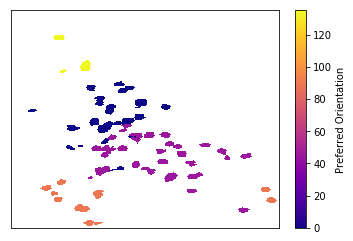

In [206]:
import glob
color_map_files = glob.glob('H:\\nhp_cells\\*ori_map.npy')
fig, ax = plt.subplots()
for file in color_map_files:
    color_map = np.load(file)
    ax.imshow(color_map, cmap=cmap, vmin=0, origin='lower', aspect='auto')
ax.set_xlim([0, 250])
ax.set_ylim([0, 252])
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(im)
cb.set_label('Preferred Orientation')
plt.savefig('H:/nhp_cells/ori_map_all.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()

In [166]:
ori_pref_files = glob.glob('H:\\nhp_cells\\*ori_pref_df.csv')
list_ = []
for file in ori_pref_files:
    df = pd.read_csv(file, index_col=0, header=0)
    list_.append(df)
ori_pref_all = pd.concat(list_)

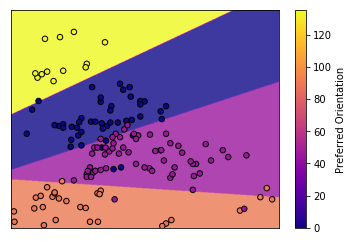

In [204]:
from matplotlib.colors import Normalize
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

xx, yy = np.meshgrid(np.linspace(0, 250, 500),
                     np.linspace(0, 252, 500))
X = ori_pref_all[['y', 'x']].as_matrix()
# scaler = StandardScaler()
# X = scaler.fit_transform(X)
Y = ori_pref_all[['ori_pref']].as_matrix().ravel()

clf = svm.NuSVC(kernel='linear', degree=1, nu=0.3, probability=True)
clf.fit(X, Y)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape[0], xx.shape[1])

fig, ax = plt.subplots()
ax.imshow(Z, interpolation='bilinear', extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
          origin='lower', cmap='plasma', alpha=0.8)
# contours = ax.contour(xx, yy, Z, levels=[-0.5, .5], linewidths=1, colors='k')
# im = ax.imshow(color_map, cmap=cmap, vmin=0, origin='lower', aspect='auto')
im = ax.scatter(X[:, 1], X[:, 0], s=30, c=Y, cmap='plasma', edgecolors='k', vmin=0, vmax=135)
ax.set_xlim([0, 250])
ax.set_ylim([0, 252])
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(im)
cb.set_label('Preferred Orientation')
plt.savefig('H:/nhp_cells/ori_map_all_fit.pdf', format='pdf', bbox_inches='tight')
plt.show()
plt.close()